In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from rdkit import Chem
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
class GCNMoleculeModel(nn.Module):
    def __init__(self, num_node_features):
        super(GCNMoleculeModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.fc = nn.Linear(64, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        
        return x.view(-1)

In [3]:
class ImprovedGCNMoleculeModel(nn.Module):
    def __init__(self, num_node_features):
        super(ImprovedGCNMoleculeModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GATConv(128, 128, heads=4, concat=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x, edge_index)))
        
        x = global_mean_pool(x, batch)  # Global mean pooling
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x.view(-1)

In [4]:
class MoleculeDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        smiles_list = df["smiles"].values
        values = df["logS"].values
        data_list = [
            (self.smiles_to_graph(smiles), torch.tensor([label], dtype=torch.float))
            for smiles, label in zip(smiles_list, values)
        ]
        self.data_list = data_list

    @staticmethod
    def smiles_to_graph(smiles):
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)
        
        node_features = []
        for atom in mol.GetAtoms():
            feature = [
                atom.GetAtomicNum(),
                atom.GetTotalDegree(),
                atom.GetFormalCharge(),
                atom.GetTotalNumHs(),
                int(atom.GetIsAromatic())
            ]
            node_features.append(feature)

        edges = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edges.append([i, j])
            edges.append([j, i])

        x = torch.tensor(node_features, dtype=torch.float)
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

        return Data(x=x, edge_index=edge_index)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

In [5]:
dataset = MoleculeDataset(csv_path="../data/delaney-rdkitfp.csv")

In [6]:
test_size = 0.2
val_size = 0.2
train_val_data, test_data = train_test_split(dataset, test_size=test_size)
train_data, val_data = train_test_split(train_val_data, test_size=val_size/(1-test_size))

In [7]:
batch_size = 8
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

In [8]:
def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [9]:
def evaluate(model, loader, device):
    model.eval()
    predictions = []
    targets = []
    total_loss = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            out = model(data)
            loss = F.mse_loss(out, target.squeeze())
            total_loss += loss.item() * data.num_graphs
            predictions.append(out.cpu())
            targets.append(target.cpu())
    
    predictions = torch.cat(predictions, dim=0).numpy()
    targets = torch.cat(targets, dim=0).numpy()
    avg_loss = total_loss / len(loader.dataset)
    return predictions, targets, avg_loss

In [20]:
# モデルの初期化
# model = GCNMoleculeModel(num_node_features=5)
model = ImprovedGCNMoleculeModel(num_node_features=5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss() 

In [21]:
# Early stoppingの設定
best_val_loss = float('inf')
patience = 10
counter = 0
num_epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loss_history = []
val_loss_history = []
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, device)
    _, _, val_loss = evaluate(model, val_loader, device)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     counter = 0
    #     torch.save(model.state_dict(), 'best_model.pth')
    # else:
    #     counter += 1
    #     if counter >= patience:
    #         print("Early stopping")
    #         break

# model.load_state_dict(torch.load('best_model.pth'))
_, _, test_loss = evaluate(model, test_loader, device)
print(f'Test Loss: {test_loss:.4f}')

Epoch: 001, Train Loss: 5.7020, Val Loss: 3.3786
Epoch: 002, Train Loss: 3.4347, Val Loss: 2.3776
Epoch: 003, Train Loss: 2.7790, Val Loss: 2.2838
Epoch: 004, Train Loss: 2.6566, Val Loss: 2.0336
Epoch: 005, Train Loss: 2.5872, Val Loss: 2.4908
Epoch: 006, Train Loss: 2.5368, Val Loss: 1.8179
Epoch: 007, Train Loss: 2.5414, Val Loss: 2.1104
Epoch: 008, Train Loss: 2.3396, Val Loss: 1.7906
Epoch: 009, Train Loss: 2.3223, Val Loss: 1.8774
Epoch: 010, Train Loss: 2.1620, Val Loss: 1.5797
Epoch: 011, Train Loss: 2.0739, Val Loss: 1.6377
Epoch: 012, Train Loss: 2.1036, Val Loss: 1.8304
Epoch: 013, Train Loss: 2.2476, Val Loss: 1.5481
Epoch: 014, Train Loss: 2.0571, Val Loss: 1.5133
Epoch: 015, Train Loss: 2.1349, Val Loss: 1.7489
Epoch: 016, Train Loss: 2.0977, Val Loss: 2.0867
Epoch: 017, Train Loss: 2.0043, Val Loss: 1.7858
Epoch: 018, Train Loss: 2.0867, Val Loss: 1.8357
Epoch: 019, Train Loss: 2.0501, Val Loss: 1.3901
Epoch: 020, Train Loss: 2.0083, Val Loss: 1.4340
Epoch: 021, Train Lo

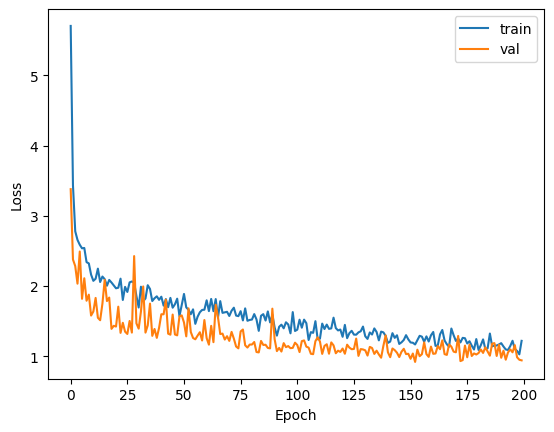

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(train_loss_history, label="train")
ax.plot(val_loss_history, label="val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
# ax.set_yscale("log")

Text(0, 0.5, 'logS (predict)')

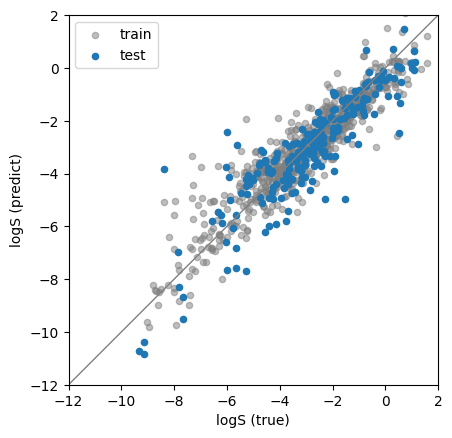

In [23]:
train_preds, train_targets, _ = evaluate(model, train_loader, device)
test_preds, test_targets, _ = evaluate(model, test_loader, device)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(train_targets, train_preds, color="tab:gray", alpha=0.5, label="train", s=20)
ax.scatter(test_targets, test_preds, color="tab:blue", label="test", s=20)
ax.plot([-12,2], [-12,2], color="gray", linewidth=1)
ax.set_xlim(-12, 2)
ax.set_ylim(-12, 2)
ax.set_aspect("equal")
ax.legend()
ax.set_xlabel("logS (true)")
ax.set_ylabel("logS (predict)")
